Use TensorFlow to implement gradient descent using backtracking for training logistic regression on the first 400 examples from the Wisconsin Breast Cancer Dataset. Perform $10^{3}$ gradient descent steps, and report the test accuracy of your final answer. In particular, your implementation should only compute gradients using TensorFlow operations. Use $\alpha=0.1$ and $\beta=0.5$ inside backtracking.

We begin by loading the data $\mathbf{X}$, to which we add a column of 1s for the bias term, with the resulting matrix $\tilde{\mathbf{X}}=\left[\mathbf{1},\mathbf{X}\right]$. We also convert the targets $y_{i}\in\left\{0,1\right\}$ to $\tilde{y}_{i}\in\left\{-1,1\right\}$.

In [13]:
import numpy as np
import tensorflow as tf
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score


data = load_breast_cancer()

# data are in rows
X_WBC = data['data']
m, n = X_WBC.shape

X_tilde = np.c_[np.ones((m, 1)), X_WBC]

# the original labels are 0/1, convert them to -1/+1, 
# and also reshape to a column vector
targets = data.target
labels = 2 * targets.reshape(-1, 1) - 1

In [5]:
#Next, we split the data into training and test sets.


train_size = 400
X_train = X_tilde[:train_size]
X_test = X_tilde[train_size:]
y_train = labels[:train_size]
y_test = labels[train_size:]


Recall that we can estimate the probability of the positive ($+1$) class using the logistic function, i.e.,

$$
P\left(y=1|\mathbf{x},\boldsymbol{\beta}\right)=\sigma\left(\tilde{\mathbf{x}}^{\mathsf{T}}\boldsymbol{\theta}\right),
$$
where

$$
\sigma\left(x\right)=\frac{1}{1+\mathrm{e}^{-x}}\quad\text{and}\quad\tilde{\mathbf{x}}=
\begin{bmatrix}
1 \\
\mathbf{x}
\end{bmatrix}
$$
We have

$$
\tilde{\mathbf{X}}=
\begin{bmatrix}
\left(\tilde{\mathbf{x}}^{\left(1\right)}\right)^{\mathsf{T}} \\
\left(\tilde{\mathbf{x}}^{\left(2\right)}\right)^{\mathsf{T}} \\
\vdots \\
\left(\tilde{\mathbf{x}}^{\left(N\right)}\right)^{\mathsf{T}}
\end{bmatrix},
$$
so that

$$
P\left(\mathbf{y}=\mathbf{1}|\mathbf{X},\boldsymbol{\theta}\right)=
\begin{bmatrix}
\sigma\left(\left(\tilde{\mathbf{x}}^{\left(1\right)}\right)^{\mathsf{T}}\boldsymbol{\theta}\right) \\
\sigma\left(\left(\tilde{\mathbf{x}}^{\left(2\right)}\right)^{\mathsf{T}}\boldsymbol{\theta}\right) \\
\vdots \\
\sigma\left(\left(\tilde{\mathbf{x}}^{\left(N\right)}\right)^{\mathsf{T}}\boldsymbol{\theta}\right) 
\end{bmatrix}
=\boldsymbol{\sigma}\left(\tilde{\mathbf{X}}\boldsymbol{\theta}\right)
$$
where $\boldsymbol{\sigma}$ denotes applying the logistic function to $\tilde{\mathbf{X}}\boldsymbol{\theta}$ element-wise, and where $N$ is the number of observations. We can now build the model.

In [6]:
# we will train on the entire training set at once (versus using a 
# subset), so strictly speaking, the placeholders could be constants
X = tf.placeholder(tf.float32, shape=[None, n + 1])
y_ = tf.placeholder(tf.float32, shape=[None, 1])

# initialize theta to the zero tensor
theta = tf.Variable(tf.zeros([n + 1, 1]))

logits = tf.matmul(X, theta)
y = tf.sigmoid(logits)

For our cost function, we will use the negative log likelihood, which is given by

$$
\ell\left(\boldsymbol{\theta}\right)=-\sum_{i=1}^{N}\log\left(\text{logit}\left(y^{\left(i\right)}\left(\tilde{\mathbf{x}}^{\left(i\right)}\right)^{\mathsf{T}}\boldsymbol{\theta}\right)\right)
$$
where

$$
\text{logit}\left(x\right)=\frac{1}{1+\mathrm{e}^{-x}}.
$$

In [7]:
f = -tf.reduce_mean(
    tf.log(
        tf.sigmoid(
            tf.multiply(y_, tf.matmul(X, theta))
        )
    )
)

In [8]:
#Next, we set some parameters and build some nodes in the computation graph.
alpha = 0.1
beta = 0.5
iter = 1000

# use automatic differentiation to calculate the 
# gradient of the objective function
df = tf.gradients(f, theta)

# we will use this variable to store backtracking iterates
theta_ = theta

# and a placeholder to update theta_
theta_new = tf.placeholder(tf.float32)

# defining these operations as nodes in the graph is 
# much faster than calling tf.assign each time
theta_bt_op = tf.assign(theta_, theta_new)
update_op = tf.assign(theta, theta_)

In [9]:
#We now define a convenience function to create predictions.
def predict(X_tilde, theta):
    '''
    Create predictions
    :param X_tilde: matrix whose ith row is (\mathbf{x}^{i}, -1)
    :param theta: predictor weights 
    '''
    probs = 1 / (1 + np.exp(-np.matmul(X_tilde, theta)))
    return probs >= 0.5

In [10]:
#Finally, we initialize the global variables and run the session.
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    
    for i in range(iter):
        # evaluate the gradient
        theta0 = theta.eval()
        df0 = sess.run(
            df, 
            feed_dict={X: X_train, y_: y_train, theta: theta0}
        )
        
        # set the gradient descent direction
        df0_arr = np.asarray(df0).reshape(-1,1)
        dx = -df0_arr
        
        # dot product doesn't work the way you think it does because 
        # numpy doesn't distinguish between 1D row and column vectors
        delta = alpha * np.dot(df0_arr.reshape(-1,), dx.reshape(-1,))
        
        # evaluate the objective function at theta0
        f0 = f.eval(
            feed_dict={X: X_train, y_: y_train, theta: theta0}
        )

        # theta = theta0 + dx
        sess.run(
            theta_bt_op, feed_dict={theta_new: theta0 + dx}
        )
        
        fx = f.eval(
            feed_dict={X: X_train, y_: y_train, theta: theta_.eval()}
        )

        t = 1
        
        # backtracking loop
        while (not np.isfinite(fx)) or fx > f0 + delta * t:
            # this is cheaper than exponentiating beta each time
            t = beta * t
            
            # theta_ = theta0 + t * dx
            sess.run(
                theta_bt_op, feed_dict={theta_new: theta0 + t * dx}
            )
            
            fx = f.eval(
                feed_dict={
                    X: X_train, y_: y_train, theta: theta_.eval()
                }
            )
        
        # update theta with the result of backtracking
        sess.run(update_op)
              
        if ((i % 100) == 0):
            y_pred = predict(X_tilde=X_train, theta=theta.eval())
            
            print(
                "LR Step:", i, 
                "\tobjective function:", fx,
                "\taccuracy:", 
                # need to use the 0/1 version here
                accuracy_score(y_pred, targets[:train_size])
            )
            
    # save the final iterate
    theta_ast = theta.eval()

LR Step: 0 	objective function: 0.66897476 	accuracy: 0.4325
LR Step: 100 	objective function: 0.42489278 	accuracy: 0.9075
LR Step: 200 	objective function: 0.36169982 	accuracy: 0.9125
LR Step: 300 	objective function: 0.305695 	accuracy: 0.91
LR Step: 400 	objective function: 0.2649914 	accuracy: 0.91
LR Step: 500 	objective function: 0.25372773 	accuracy: 0.91
LR Step: 600 	objective function: 0.24462037 	accuracy: 0.9075
LR Step: 700 	objective function: 0.23653342 	accuracy: 0.91
LR Step: 800 	objective function: 0.23039341 	accuracy: 0.9125
LR Step: 900 	objective function: 0.22504833 	accuracy: 0.9125


In [12]:
#calculate the accuracy of the model
accuracy_score(
    targets[train_size:], 
    predict(X_test, theta_ast)
)

0.9289940828402367

## Excercise 2
Consider the 3 by 2 by 2 by 2 tensor $\mathsf{A}$ given by

$$
\mathsf{A}=\left[\left[\begin{bmatrix}1 &amp; -1\\
-2 &amp; 1
\end{bmatrix},\begin{bmatrix}1 &amp; 1\\
-2 &amp; 2
\end{bmatrix}\right],\left[\begin{bmatrix}2 &amp; -1\\
-1 &amp; 1
\end{bmatrix},\begin{bmatrix}2 &amp; 1\\
1 &amp; 2
\end{bmatrix}\right],\left[\begin{bmatrix}1 &amp; -2\\
-2 &amp; 1
\end{bmatrix},\begin{bmatrix}1 &amp; 1\\
-1 &amp; 1
\end{bmatrix}\right]\right]
$$
and

$$
\mathbf{B}=\begin{bmatrix}b_{1,1} &amp; b_{1,2}\\
b_{2,1} &amp; b_{2,2}
\end{bmatrix}=\begin{bmatrix}1 &amp; -1\\
-2 &amp; 2
\end{bmatrix}.
$$
Let $\mathcal{F}$ denote the contraction of $\mathsf{A}$ with $\mathbf{B}$ along the $\mathbf{i}=\left\{ 2,3\right\}$ and $\mathbf{j}=\left\{ 1,2\right\}$ indices. That is,

$$
f_{i_{1},i_{2}}=\sum_{k_{1}=1}^{2}\sum_{k_{2}=1}^{2}a_{i_{1},k_{1},k_{2},i_{2}}b_{k_{1},k_{2}}.
$$
### Part (a)
What are the order and shape of $\mathcal{F}$?

Let $\mathbf{n}=\left(3,2,2,2\right)$, and observe that $\mathsf{A}\in\mathscr{F}_{\mathbf{n}}$, i.e., $\mathsf{A}$ is a fourth order tensor. Similarly, let $\mathbf{m}=\left(2,2\right)$, and observe that $\mathbf{B}\in\mathscr{F}_{\mathbf{m}}$, i.e., $\mathbf{B}$ is a second order tensor. Noting that

$$ \mathbf{n}_{\setminus\mathbf{i}}=\left(3,2\right)\quad\text{and}\quad\mathbf{m}_{\setminus\mathbf{j}}=\left(\right)\implies\mathbf{n}_{\setminus\mathbf{i}}\oplus\mathbf{m}_{\setminus\mathbf{j}}=\left(3,2\right), $$
we have the tensor contraction operator

$$
c_{\mathbf{i},\mathbf{j}}:\mathscr{F}_{\mathbf{n}}\times\mathscr{F}_{\mathbf{m}}\rightarrow\mathscr{F}_{\mathbf{n}_{\setminus\mathbf{i}}\oplus\mathbf{m}_{\setminus\mathbf{j}}}=\mathscr{F}_{\left(3,2\right)}.
$$
Thus, $\mathcal{F}$ is a second order tensor with dimensions $3\times2$, i.e., a matrix with 3 rows and 2 columns.

### Part (b)
Compute all the entries of $\mathcal{F}$ by hand, showing your work. Check your answer using TensorFlow's tensordot function.

To make the indexing easier, let $\mathbf{A}_{i,j}$ be the $2\times2$ matrix defined by

$$
\mathbf{A}_{i,j}=\begin{bmatrix}a_{i,j,1,1} &amp; a_{i,j,1,2}\\
a_{i,j,2,1} &amp; a_{i,j,2,2}
\end{bmatrix},
$$
so that

$$
\mathsf{A}=\left[\left[\mathbf{A}_{1,1},\mathbf{A}_{1,2}\right],\left[\mathbf{A}_{2,1},\mathbf{A}_{2,2}\right],\left[\mathbf{A}_{3,1},\mathbf{A}_{3,2}\right]\right].
$$
We have

$$
\begin{align*}
f_{i_{1},i_{2}} &amp; =\sum_{k_{1}=1}^{2}\sum_{k_{2}=1}^{2}a_{i_{1},k_{1},k_{2},i_{2}}b_{k_{1},k_{2}}\\
 &amp; =\sum_{k_{1}=1}^{2}\left(a_{i_{1},k_{1},1,i_{2}}b_{k_{1},1}+a_{i_{1},k_{1},2,i_{2}}b_{k_{1},2}\right)\\
 &amp; =a_{i_{1},1,1,i_{2}}b_{1,1}+a_{i_{1},1,2,i_{2}}b_{1,2}+a_{i_{1},2,1,i_{2}}b_{2,1}+a_{i_{1},2,2,i_{2}}b_{2,2},
\end{align*}
$$
where $i_{1}\in\left\{ 1,2,3\right\}$ and $i_{2}\in\left\{ 1,2\right\}$. Denote by $\mathbf{C}_{i}$ the $i\text{th}$ column of $\mathbf{C}\in M_{m,n}$, and observe that $f_{i_{1},i_{2}}$ is equal to

$$
\left(\mathbf{A}_{i_{1},1}\right)_{i_{2}}^{\mathsf{T}}\left(\mathbf{B}^{\mathsf{T}}\right)_{1}+\left(\mathbf{A}_{i_{1},2}\right)_{i_{2}}^{\mathsf{T}}\left(\mathbf{B}^{\mathsf{T}}\right)_{2},
$$
i.e., $f_{i_{1},i_{2}}$ is the dot product of the $i_{2}\text{th}$ column of $\mathbf{A}_{i_{1},1}$ and the first row of $\mathbf{B}$ plus the dot product of the $i_{2}\text{th}$ row of $\mathbf{A}_{i_{1},2}$ and the second row of $\mathbf{B}$. Then, we have

$$
\begin{align*}
f_{1,1} &amp; =a_{1,1,1,1}b_{1,1}+a_{1,1,2,1}b_{1,2}+a_{1,2,1,1}b_{2,1}+a_{1,2,2,1}b_{2,2}\\
 &amp; =1\cdot1+\left(-2\right)\left(-1\right)+1\left(-2\right)+\left(-2\right)2\\
 &amp; =-3\\
f_{1,2} &amp; =a_{1,1,1,2}b_{1,1}+a_{1,1,2,2}b_{1,2}+a_{1,2,1,2}b_{2,1}+a_{1,2,2,2}b_{2,2}\\
 &amp; =\left(-1\right)1+1\left(-1\right)+1\left(-2\right)+2\cdot2\\
 &amp; =0\\
f_{2,1} &amp; =a_{2,1,1,1}b_{1,1}+a_{2,1,2,1}b_{1,2}+a_{2,2,1,1}b_{2,1}+a_{2,2,2,1}b_{2,2}\\
 &amp; =2\cdot1+\left(-1\right)\left(-1\right)+2\left(-2\right)+1\cdot2\\
 &amp; =1\\
f_{2,2} &amp; =a_{2,1,1,2}b_{1,1}+a_{2,1,2,2}b_{1,2}+a_{2,2,1,2}b_{2,1}+a_{2,2,2,2}b_{2,2}\\
 &amp; =\left(-1\right)1+1\left(-1\right)+1\left(-2\right)+2\cdot2\\
 &amp; =0\\
f_{3,1} &amp; =a_{3,1,1,1}b_{1,1}+a_{3,1,2,1}b_{1,2}+a_{3,2,1,1}b_{2,1}+a_{3,2,2,1}b_{2,2}\\
 &amp; =1\cdot1+\left(-2\right)\left(-1\right)+1\left(-2\right)+\left(-1\right)2\\
 &amp; =-1\\
f_{3,2} &amp; =a_{3,1,1,2}b_{1,1}+a_{3,1,2,2}b_{1,2}+a_{3,2,1,2}b_{2,1}+a_{3,2,2,2}b_{2,2}\\
 &amp; =\left(-2\right)1+1\left(-1\right)+1\left(-2\right)+1\cdot2\\
 &amp; =-3,
\end{align*}
$$
so that

$$
\mathcal{F}=\begin{bmatrix}-3 &amp; 0\\
1 &amp; 0\\
-1 &amp; -3
\end{bmatrix}.
$$
We now check our expression for $\mathcal{F}$ using tensordot.

In [15]:
A = tf.Variable(
    [
        [
            [
                [1, -1], [-2, 1]
            ],
            [
                [1, 1], [-2, 2]
            ]
        ],
        [
            [
                [2, -1], [-1, 1]
            ],
            [
                [2, 1], [1, 2]
            ]
        ],
        [
            [
                [1, -2], [-2, 1]
            ],
            [
                [1, 1], [-1, 1]
            ]
        ]
    ], 
    name='A'
)

B = tf.Variable(
    [
        [1, -1], [-2, 2]
    ], name='B'
)

f = tf.tensordot(A, B, [[1, 2], [0, 1]])

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    result = f.eval()

result

array([[-3,  0],
       [ 1,  0],
       [-1, -3]], dtype=int32)

In [ ]:
#We see that the result of tensordot agrees with our expression for $\mathcal{F}$.
from sklearn.datasets import load_breast_cancer
import numpy as np
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")
def logit(x):
    return 1/(1+np.exp(-x))
    
def loglogit(x):
    returnnp.log(1+np.exp(-x))
    
def loglogitlikelihood(X,y):
    tildeX=np.hstack([np.ones((X.shape[0],1)),X])
    
    f=lambda b:np.mean(loglogit(np.multiply(y,tildeX@b)))
    df=lambda b:-tildeX.T@np.multiply(y,logit(-np.multiply(y,tildeX@b)))/X.shape[0]
    d2f=lambda b:tildeX.T@np.diag(logit(tildeX@b)*logit(-tildeX@b))@tildeX/X.shape[0]
    return f,df,d2f

def lr_accuracy(b,X,targets):
    tildeX=np.hstack([np.ones((X.shape[0],1)),X])
    y_guess=np.zeros(X.shape[0])
    y_guess[logit(tildeX@b)>0.5]=1
    return np.mean(np.equal(targets,y_guess))

data=load_breast_cancer()
# Parameters for the data
dim_data=30
num_labels=2
num_examples=569
# Parameters for training
learning_rate=1e-6
num_train=400
X=data['data']
# Data in rows
X=np.concatenate([np.ones((X.shape[0],1)),X],axis=1)
targets=data.target# 0-1 labels
labels=2*targets-1 # Converts 0-1 labels to -1 +1 labels

# 0-1 labelslabels=2*targets-1# Converts 0-1 labels to -1 +1 labels
# Let's use TensorFlow to train logisitic regression 
x=tf.placeholder(tf.float32,shape=[None,dim_data+1])
y_=tf.placeholder(tf.float32,shape=[None,1])
b=tf.Variable(tf.zeros([dim_data+1,1]))
b_bt=tf.Variable(tf.zeros([dim_data+1,1]))
nll_bt=tf.reduce_mean(-tf.log(1/(1+tf.exp(y_*x@b_bt))))
nll=tf.reduce_mean(-tf.log(1/(1+tf.exp(y_*x@b))))
sess=tf.Session()
sess.run(tf.global_variables_initializer())
alpha=0.1
beta=0.5
for i in range(1000):
    df=np.reshape(sess.run(tf.gradients(nll,b),feed_dict={x:X[:num_train,:],y_:np.reshape(labels[:num_train],(num_train,1))}),[31,1])
    df_a=np.reshape(df,31)
    delta=-np.sum(df_a*df_a)*alpha
    t=1
    sess.run(tf.assign(b_bt,sess.run(b)-t*df))
    fval=sess.run(nll_bt,feed_dict={x:X[:num_train,:],y_:np.reshape(labels[:num_train],(num_train,1))})
    
    f0=sess.run(nll,feed_dict={x:X[:num_train,:],y_:np.reshape(labels[:num_train],(num_train,1))})
    while (not np.isfinite) or fval>f0-delta*t:
        t=beta*t
        sess.run(tf.assign(b_bt,sess.run(b)-t*df))
        fval=sess.run(nll_bt,feed_dict={x:X[:num_train,:],y_:np.reshape(labels[:num_train],(num_train,1))})
    
    sess.run(tf.assign(b,sess.run(b_bt)))
    print('Training accuracy: ',lr_accuracy(np.reshape(sess.run(b),31),data['data'][:400,:],targets[:400]))


print('accuracy: ',lr_accuracy(np.reshape(sess.run(b),31),data['data'][400:,:],targets[400:]))
sess.close()

Training accuracy:  0.5675
Training accuracy:  0.5675
Training accuracy:  0.5675
Training accuracy:  0.5675
Training accuracy:  0.5675
Training accuracy:  0.5675
Training accuracy:  0.5675
Training accuracy:  0.5575
Training accuracy:  0.5675
Training accuracy:  0.56
Training accuracy:  0.5675
Training accuracy:  0.5575
Training accuracy:  0.5675
Training accuracy:  0.5625
Training accuracy:  0.5675
Training accuracy:  0.545
Training accuracy:  0.5675
Training accuracy:  0.505
Training accuracy:  0.5675
Training accuracy:  0.4575
Training accuracy:  0.5575
Training accuracy:  0.095
Training accuracy:  0.5225
Training accuracy:  0.1925
Training accuracy:  0.55
Training accuracy:  0.1025
Training accuracy:  0.4775
Training accuracy:  0.1575
Training accuracy:  0.525
Training accuracy:  0.1025
Training accuracy:  0.3825
Training accuracy:  0.14
Training accuracy:  0.47
Training accuracy:  0.0925
Training accuracy:  0.275
Training accuracy:  0.145
Training accuracy:  0.3175
Training accura

## Excercise 3

### Part a

Our dataset contains 505 rows of data and 13 fields (after cleaning). 

Our dataset does not contain spatial or temporal fields.

Our dataset does not contain categorical fields.

### Part b

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('S&P.csv' , sep=',', encoding='latin1')

In [16]:
#drop the row "Price\Book" this column contains too many missing value almost 400 
df=df.drop(['Price/Book'], axis=1)

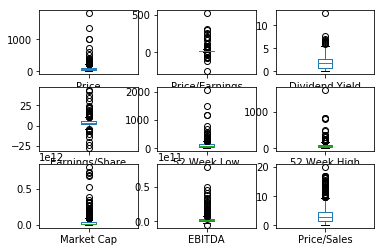

In [18]:
numeric_col=['Price','Price/Earnings','Dividend Yield','Earnings/Share','52 Week Low','52 Week High',
               'Market Cap','EBITDA','Price/Sales']
df_numeric=df[numeric_col]
df_numeric.plot(kind='box', subplots=True, layout=(3, 3), sharex=False, sharey=False)
plt.show()

### Part c


/Users/tianjingrong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  


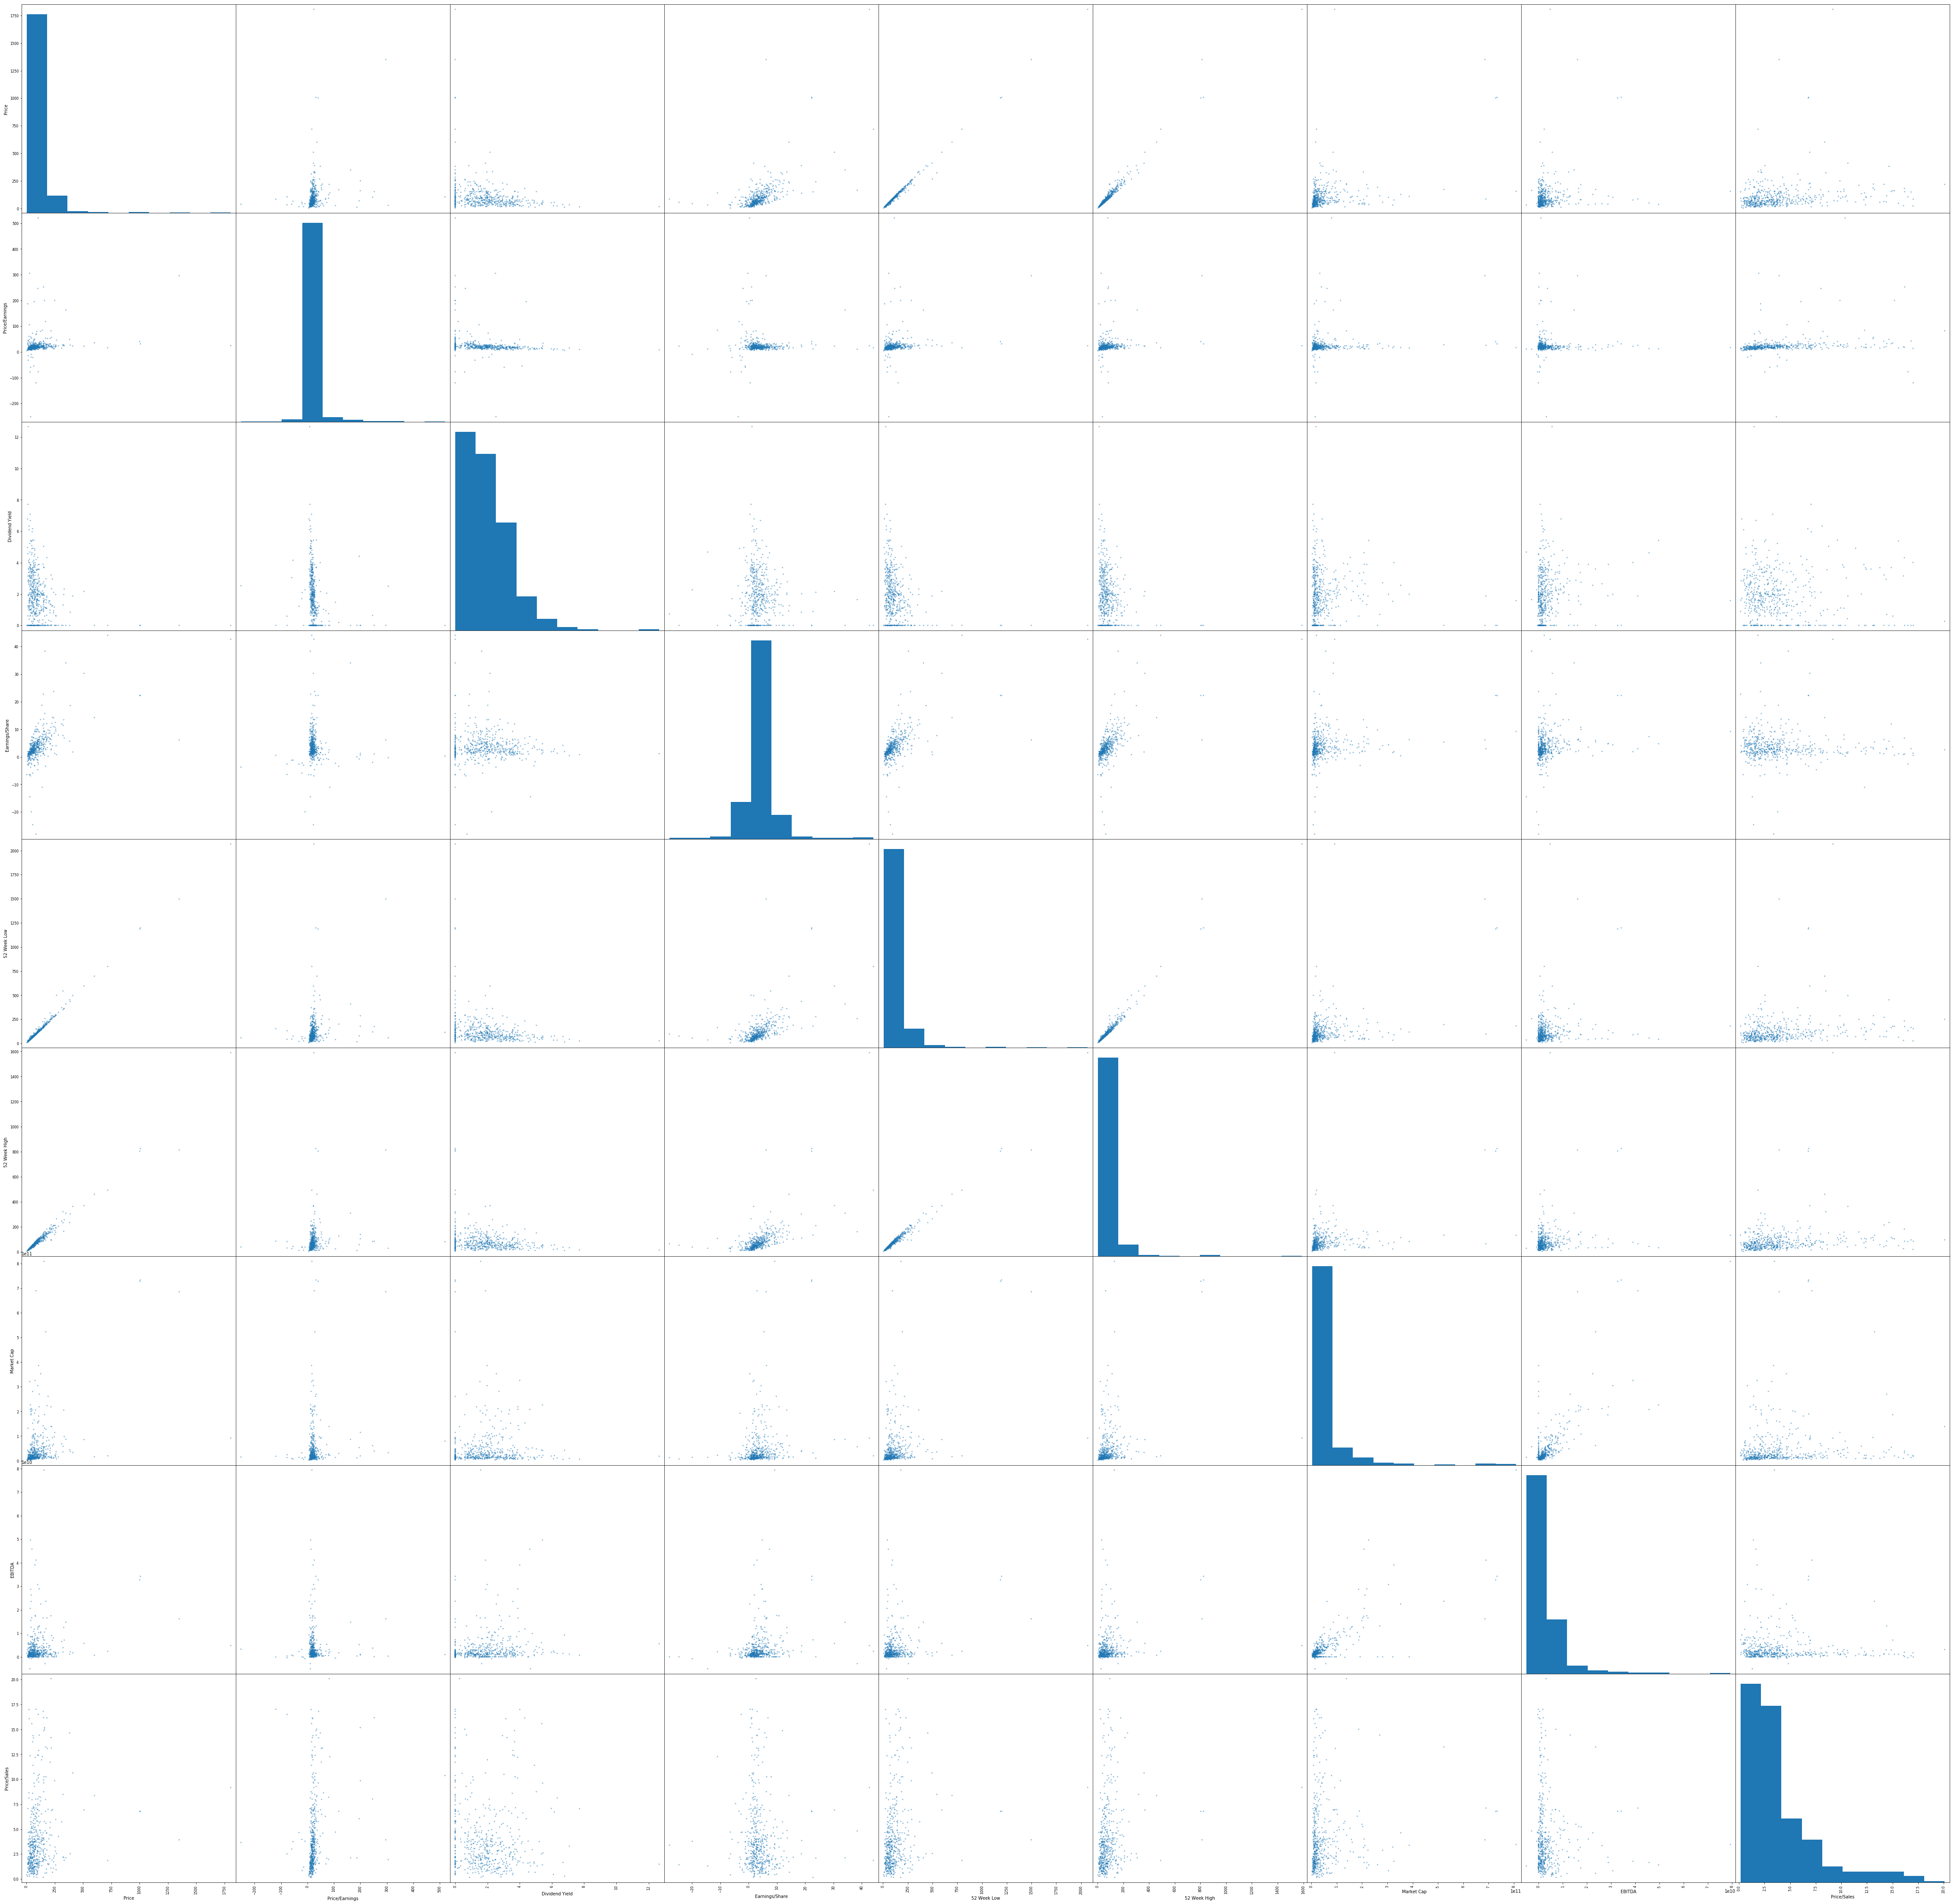

In [22]:
from pandas.tools.plotting import scatter_matrix
scatter_matrix(cf[["Price","Price/Earnings", "Dividend Yield","Earnings/Share","52 Week Low","52 Week High","Market Cap", "EBITDA","Price/Sales"]])
plt.rcParams["figure.figsize"]=(80,80)